### Import Libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
df=pd.read_csv("weather_classification_data.csv")
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy


### Variables

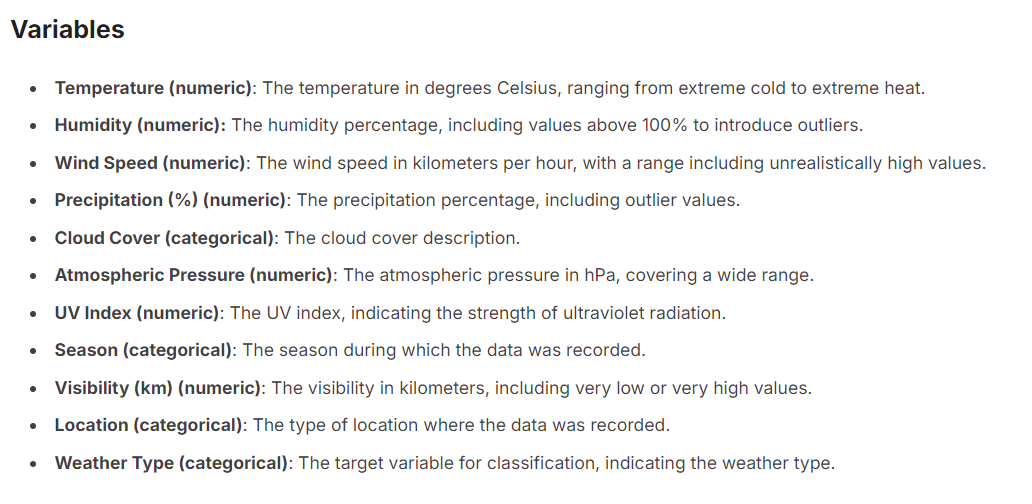

In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,13200.0,19.127576,17.386327,-25.00,4.0,21.00,31.0000,109.00
Humidity,13200.0,68.710833,20.194248,20.00,57.0,70.00,84.0000,109.00
Wind Speed,13200.0,9.832197,6.908704,0.00,5.0,9.00,13.5000,48.50
Precipitation (%),13200.0,53.644394,31.946541,0.00,19.0,58.00,82.0000,109.00
Atmospheric Pressure,13200.0,1005.827896,37.199589,800.12,994.8,1007.65,1016.7725,1199.21
UV Index,13200.0,4.005758,3.856600,0.00,1.0,3.00,7.0000,14.00
Visibility (km),13200.0,5.462917,3.371499,0.00,3.0,5.00,7.5000,20.00


In [51]:
df.shape

(13200, 11)

## Feature Engineering

In [52]:
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5 / 9

def calculate_heat_index(df, temp_col, humidity_col):
    T = celsius_to_fahrenheit(df[temp_col])
    R = df[humidity_col]
    
    HI = (
        -42.379 + 2.04901523 * T + 10.14333127 * R 
        - 0.22475541 * T * R - 6.83783e-3 * T**2 
        - 5.481717e-2 * R**2 + 1.22874e-3 * T**2 * R 
        + 8.5282e-4 * T * R**2 - 1.99e-6 * T**2 * R**2
    )
    
    return HI
def calculate_wind_chill(row):
    T = row['Temperature']
    V = row['Wind Speed']
    wind_chill = (13.12 + 0.6215 * T 
                  - 11.37 * (V ** 0.16) 
                  + 0.3965 * T * (V ** 0.16))
    return wind_chill
a = 17.27
b = 237.7

def calculate_alpha(T, RH):
    return (a * T) / (b + T) + np.log(RH / 100.0)
def calculate_dew_point(row):
    alpha = calculate_alpha(row['Temperature'], row['Humidity'])
    return (b * alpha) / (a - alpha)
df['Dew Point'] = df.apply(calculate_dew_point, axis=1)
df['Heat Index'] = calculate_heat_index(df, 'Temperature', 'Humidity')
df['Heat Index'] = fahrenheit_to_celsius(df['Heat Index'])
df['Wind Chill'] = df.apply(calculate_wind_chill, axis=1)

In [53]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Dew Point,Heat Index,Wind Chill
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy,9.235075,27.245780,13.478732
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy,38.240728,94.895230,43.123533
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny,22.429394,33.663662,32.481762
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny,34.592524,74.134442,40.681791
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy,21.958576,29.196183,28.854897


### Checking Nulls

In [54]:
df.isnull().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
Dew Point               0
Heat Index              0
Wind Chill              0
dtype: int64

In [55]:
df["Weather Type"].value_counts()

Weather Type
Rainy     3300
Cloudy    3300
Sunny     3300
Snowy     3300
Name: count, dtype: int64

In [56]:
df["Weather Type"].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

### Encoding

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Weather Type'] = le.fit_transform(df['Weather Type'])
df = pd.get_dummies(df, columns=['Cloud Cover', 'Season','Location'], drop_first=True, dtype=int)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'Cloudy': 0, 'Rainy': 1, 'Snowy': 2, 'Sunny': 3}


### Co-relation Matrix

<Axes: >

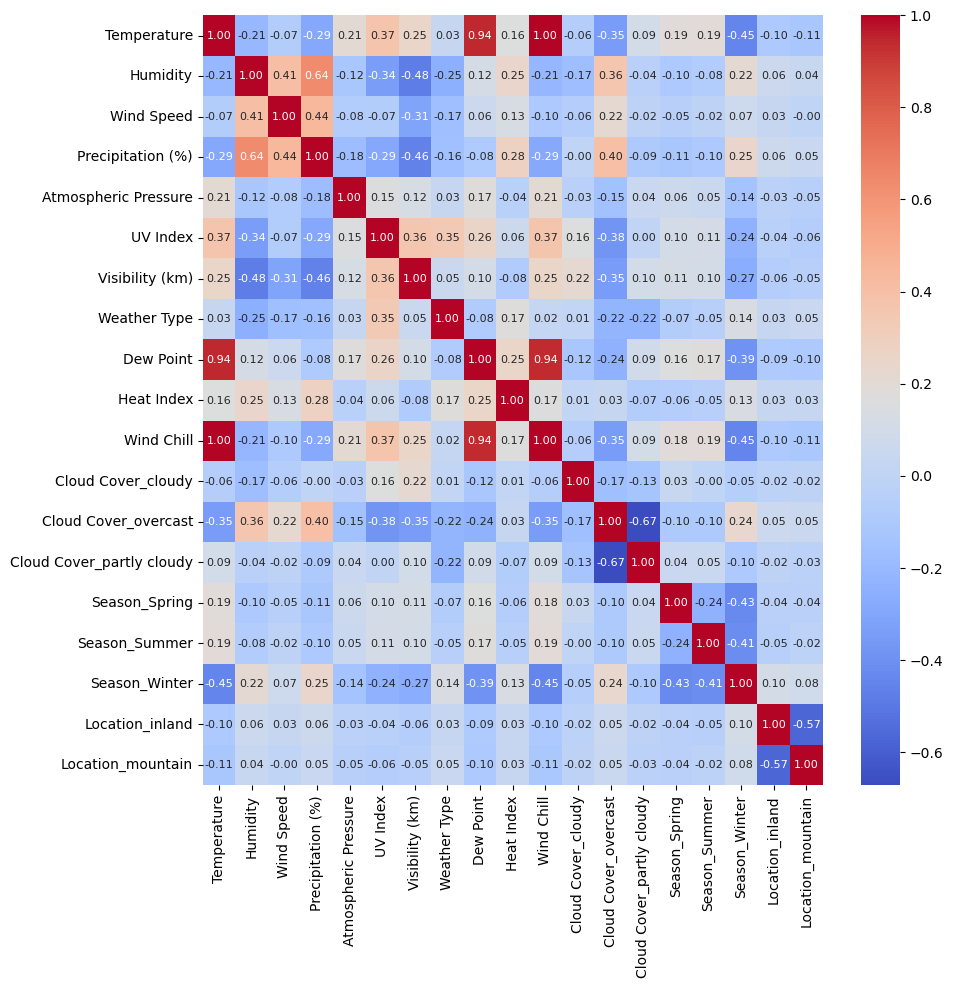

In [58]:
corr_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})

In [59]:
corr_matrix['Weather Type'].sort_values()

Humidity                    -0.250558
Cloud Cover_overcast        -0.224957
Cloud Cover_partly cloudy   -0.224718
Wind Speed                  -0.166485
Precipitation (%)           -0.161578
Dew Point                   -0.078911
Season_Spring               -0.067318
Season_Summer               -0.045884
Cloud Cover_cloudy           0.009168
Wind Chill                   0.022713
Location_inland              0.026744
Temperature                  0.028923
Atmospheric Pressure         0.030679
Location_mountain            0.045542
Visibility (km)              0.047448
Season_Winter                0.135562
Heat Index                   0.170936
UV Index                     0.345804
Weather Type                 1.000000
Name: Weather Type, dtype: float64

### Checking if the target is Imbalanced

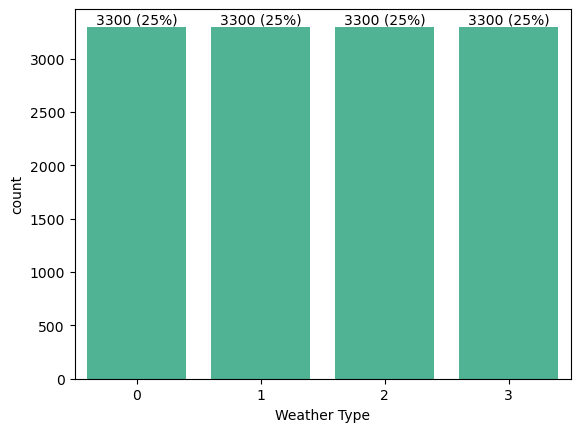

In [60]:
sns.countplot(x='Weather Type', data=df, color='#3EC49B')

for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)} ({height/sum(df["Weather Type"].value_counts())*100:.0f}%)',
                        xy=(p.get_x() + p.get_width()/2, height), 
                        ha='center', 
                        va='bottom')

plt.show()

In [61]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Weather Type,Dew Point,Heat Index,Wind Chill,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain
0,14,73,9.5,82,1010.82,2,3.5,1,9.235075,27.245780,13.478732,0,0,1,0,0,1,1,0
1,39,96,8.5,71,1011.43,7,10.0,0,38.240728,94.895230,43.123533,0,0,1,1,0,0,1,0
2,30,64,7.0,16,1018.72,5,5.5,3,22.429394,33.663662,32.481762,0,0,0,1,0,0,0,1
3,38,83,1.5,82,1026.25,7,1.0,3,34.592524,74.134442,40.681791,0,0,0,1,0,0,0,0
4,27,74,17.0,66,990.67,1,2.5,1,21.958576,29.196183,28.854897,0,1,0,0,0,1,0,1


### Model Traning

In [62]:
from sklearn.model_selection import train_test_split,GridSearchCV
X=df.drop("Weather Type",axis=1)
Y=df["Weather Type"]

In [63]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=42,test_size=0.2)

In [64]:
from sklearn.preprocessing import StandardScaler
SC=StandardScaler()
X_train_scaled=SC.fit_transform(X_train)
X_test_scaled=SC.transform(X_test)
X_train_scaled=pd.DataFrame(X_train_scaled)
X_test_scaled=pd.DataFrame(X_test_scaled)

In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

model = XGBClassifier(eval_metric='logloss', tree_method='hist',device='cuda')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                   n_iter=10, scoring='accuracy', cv=3, verbose=1, random_state=42)

random_search.fit(X_train_scaled, Y_train)

print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Test Accuracy: 91.74%
Confusion Matrix:
[[587  32  18  14]
 [ 31 594  13   9]
 [ 16   8 666  11]
 [ 26  19  21 575]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       651
           1       0.91      0.92      0.91       647
           2       0.93      0.95      0.94       701
           3       0.94      0.90      0.92       641

    accuracy                           0.92      2640
   macro avg       0.92      0.92      0.92      2640
weighted avg       0.92      0.92      0.92      2640



### Saving Model in Pickle

In [66]:
import pickle
filename = 'weather_type.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [67]:
filename = 'weather_type.sav'
model = pickle.load(open(filename, 'rb'))

In [68]:
model.feature_names_in_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17'], dtype='<U2')

### Input by Preprocessing

In [69]:
data_raw=pd.read_csv("weather_classification_data.csv")

In [70]:
data_raw = data_raw.drop("Weather Type",axis=1)

### Preprocessing step 1 KPI Creation

In [71]:
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5 / 9

def calculate_heat_index(df, temp_col, humidity_col):
    T = celsius_to_fahrenheit(df[temp_col])
    R = df[humidity_col]
    
    HI = (
        -42.379 + 2.04901523 * T + 10.14333127 * R 
        - 0.22475541 * T * R - 6.83783e-3 * T**2 
        - 5.481717e-2 * R**2 + 1.22874e-3 * T**2 * R 
        + 8.5282e-4 * T * R**2 - 1.99e-6 * T**2 * R**2
    )
    
    return HI
def calculate_wind_chill(row):
    T = row['Temperature']
    V = row['Wind Speed']
    wind_chill = (13.12 + 0.6215 * T 
                  - 11.37 * (V ** 0.16) 
                  + 0.3965 * T * (V ** 0.16))
    return wind_chill
a = 17.27
b = 237.7

def calculate_alpha(T, RH):
    return (a * T) / (b + T) + np.log(RH / 100.0)
def calculate_dew_point(row):
    alpha = calculate_alpha(row['Temperature'], row['Humidity'])
    return (b * alpha) / (a - alpha)
data_raw['Dew Point'] = data_raw.apply(calculate_dew_point, axis=1)
data_raw['Heat Index'] = calculate_heat_index(data_raw, 'Temperature', 'Humidity')
data_raw['Heat Index'] = fahrenheit_to_celsius(data_raw['Heat Index'])
data_raw['Wind Chill'] = data_raw.apply(calculate_wind_chill, axis=1)

### Step 2 One-Hot Encoding

In [72]:
data_raw = pd.get_dummies(data_raw, columns=['Cloud Cover', 'Season','Location'], drop_first=True, dtype=int)

In [73]:
data_raw.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Dew Point,Heat Index,Wind Chill,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain
0,14,73,9.5,82,1010.82,2,3.5,9.235075,27.245780,13.478732,0,0,1,0,0,1,1,0
1,39,96,8.5,71,1011.43,7,10.0,38.240728,94.895230,43.123533,0,0,1,1,0,0,1,0
2,30,64,7.0,16,1018.72,5,5.5,22.429394,33.663662,32.481762,0,0,0,1,0,0,0,1
3,38,83,1.5,82,1026.25,7,1.0,34.592524,74.134442,40.681791,0,0,0,1,0,0,0,0
4,27,74,17.0,66,990.67,1,2.5,21.958576,29.196183,28.854897,0,1,0,0,0,1,0,1


In [74]:
random_row = data_raw.sample(n=1, random_state=np.random.randint(1, 1000))
random_row_df = random_row.copy()
random_row_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Dew Point,Heat Index,Wind Chill,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Spring,Season_Summer,Season_Winter,Location_inland,Location_mountain
9157,13,95,12.0,65,1016.47,3,2.5,12.21713,18.718704,11.949429,0,1,0,0,0,1,1,0


### Step 3 Scaling

In [75]:
random_row_df =SC.transform(random_row_df)

### Loading Model

In [76]:
filename = 'weather_type.sav'
model = pickle.load(open(filename, 'rb'))

{'Cloudy': 0, 'Rainy': 1, 'Snowy': 2, 'Sunny': 3}

In [77]:
output = model.predict(random_row_df)
result = output[0]
result

1

### Creating Pipeline

In [78]:
df=pd.read_csv("weather_classification_data.csv")

### Feature Engineering

In [79]:
def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5 / 9

def calculate_heat_index(df, temp_col, humidity_col):
    T = celsius_to_fahrenheit(df[temp_col])
    R = df[humidity_col]
    
    HI = (
        -42.379 + 2.04901523 * T + 10.14333127 * R 
        - 0.22475541 * T * R - 6.83783e-3 * T**2 
        - 5.481717e-2 * R**2 + 1.22874e-3 * T**2 * R 
        + 8.5282e-4 * T * R**2 - 1.99e-6 * T**2 * R**2
    )
    
    return HI
def calculate_wind_chill(row):
    T = row['Temperature']
    V = row['Wind Speed']
    wind_chill = (13.12 + 0.6215 * T 
                  - 11.37 * (V ** 0.16) 
                  + 0.3965 * T * (V ** 0.16))
    return wind_chill
a = 17.27
b = 237.7

def calculate_alpha(T, RH):
    return (a * T) / (b + T) + np.log(RH / 100.0)
def calculate_dew_point(row):
    alpha = calculate_alpha(row['Temperature'], row['Humidity'])
    return (b * alpha) / (a - alpha)
df['Dew Point'] = df.apply(calculate_dew_point, axis=1)
df['Heat Index'] = calculate_heat_index(df, 'Temperature', 'Humidity')
df['Heat Index'] = fahrenheit_to_celsius(df['Heat Index'])
df['Wind Chill'] = df.apply(calculate_wind_chill, axis=1)

### Train Test Split

In [80]:
from sklearn.model_selection import train_test_split
X=df.drop("Weather Type",axis=1)
Y=df["Weather Type"]
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

In [81]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=42,test_size=0.2)

### Seperating Features

In [82]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()
print(numeric_features)
print(categorical_features)

['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)', 'Dew Point', 'Heat Index', 'Wind Chill']
['Cloud Cover', 'Season', 'Location']


### Pipeline for Pre-processing

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### Defining Model

In [84]:
model = XGBClassifier(eval_metric='logloss', tree_method='hist',device='cuda')

### Final Pipeline

In [85]:
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

In [86]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__gamma': [0, 0.1, 0.2, 0.3],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [1, 1.5, 2]
}

In [87]:
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, 
                                   n_iter=10, scoring='accuracy', cv=3, verbose=1, random_state=42)

random_search.fit(X_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['Temperature',
                                                                                'Humidity',
                                                                                'Wind '
                                                                                'Speed',
                                                                                'Precipitation '
                                                                                '(%)',
                                                                                'Atmospheric '
                                                                                'Pressure',
                                                                                'UV '
                                                                                'Index',
                                                                                'Visibility '
                                                                                '(km)',
                                                                                'Dew '
                                                                                'Point',
                                                                                'Heat '
                                                                                'Index',
                                                                                'Wind '
                                                                                'Chill']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('...
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2, 0.3],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 4, 5, 6],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__reg_alpha': [0, 0.1, 0.5],
                                        'classifier__reg_lambda': [1, 1.5, 2],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [88]:
print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Best Hyperparameters: {'classifier__subsample': 1.0, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 5, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.6}
Test Accuracy: 91.44%
Confusion Matrix:
[[583  36  20  12]
 [ 33 585  19  10]
 [ 15  12 667   7]
 [ 28  15  19 579]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       651
           1       0.90      0.90      0.90       647
           2       0.92      0.95      0.94       701
           3       0.95      0.90      0.93       641

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



In [89]:
import pickle
filename = 'weather_type.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [90]:
filename = 'weather_type.sav'
model = pickle.load(open(filename, 'rb'))

In [91]:
model.feature_names_in_

array(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Season',
       'Visibility (km)', 'Location', 'Dew Point', 'Heat Index',
       'Wind Chill'], dtype=object)